In [1]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import keras
import keras.layers as layers
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold, train_test_split
from sklearn.metrics import confusion_matrix

2024-05-25 20:10:25.151744: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 20:10:25.688344: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
DataSolarModules = pd.read_json('InfraredSolarModules/module_metadata.json').transpose().sort_index()
DataSolarModulesVAE = pd.read_json('InfraredSolarModules/VAE_metadata.json').transpose().sort_index()
Classes = DataSolarModules['anomaly_class'].unique()
class_to_number = dict(enumerate(Classes.flatten(), 0))
class_to_number = {v: k for k, v in class_to_number.items()}

In [3]:
def map_to_class(value):
    class_to_number
    return class_to_number.get(value, 'Unknown')

DataSolarModules['class_code'] = DataSolarModules['anomaly_class'].apply(map_to_class)
DataSolarModulesVAE['class_code'] = DataSolarModulesVAE['anomaly_class'].apply(map_to_class)

In [4]:
def read_images_dataframe(dataframe):
    images = []
    for image_path in dataframe['image_filepath']:
        img = cv2.imread("InfraredSolarModules/"+image_path,cv2.IMREAD_GRAYSCALE)
        img = img.reshape(40, 24).astype("float32") / 255
        images.append(img)
    images=np.array(images) 
    return images

def read_labels_dataframe(dataframe):
    labels = []
    for label in dataframe['class_code']:
        labels.append(label)
    labels=np.array(labels) 
    labels.astype("int32")   
    return labels

In [5]:
images = read_images_dataframe(DataSolarModules)
imagesVAE = read_images_dataframe(DataSolarModulesVAE)
labels = read_labels_dataframe(DataSolarModules)
labelsVAE = read_labels_dataframe(DataSolarModulesVAE)

In [6]:
images = np.concatenate((images, imagesVAE), axis=0)
labels = np.concatenate((labels, labelsVAE), axis=0)

In [7]:
# Create a testing set with 25 images per class
num_images_per_class = 40

def create_testing_set(dataframe, num_images_per_class):
    test_indices = []
    for cls in dataframe['class_code'].unique():
        class_indices = dataframe[dataframe['class_code'] == cls].index[:num_images_per_class].tolist()
        test_indices.extend(class_indices)
    return test_indices

test_indices = create_testing_set(DataSolarModules, num_images_per_class)
data_test = np.array(test_indices)

# Create a training set with the remaining images
data_train = np.setdiff1d(np.arange(len(images)), data_test)

In [8]:
inputs = keras.Input(shape=(40, 24, 1))


x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)

x = layers.Flatten()(x)

x = layers.Dense(2048, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(128, activation="relu")(x)


outputs = layers.Dense(12, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

2024-05-25 20:10:30.542107: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-25 20:10:30.577459: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-25 20:10:30.577762: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 40, 24, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 38, 22, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 11, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 9, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 2, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,386,956 (16.73 MB)

 Trainable params: 4,386,956 (16.73 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
batch_size = 64
n_epochs = 25

optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)

rkf = RepeatedKFold(n_splits=6, n_repeats=3, random_state=21312312)

model.compile(optimizer=optimizer,                                    
              loss="sparse_categorical_crossentropy",                 
              metrics=["accuracy"])   

In [10]:
fold_no = 1
acc_per_fold = []
loss_per_fold = []

all_train_losses = []
all_train_accuracies = []
all_val_losses = []
all_val_accuracies = []

for train, val in rkf.split(data_train):

    history_model = model.fit(images[train], labels[train],
                              epochs=n_epochs,
                              validation_data=(images[val], labels[val]),
                              batch_size=batch_size)

    # Store metrics for this fold
    fold_train_loss = np.mean(history_model.history['loss'])
    fold_train_accuracy = np.mean(history_model.history['accuracy'])
    fold_val_loss = np.mean(history_model.history['val_loss'])
    fold_val_accuracy = np.mean(history_model.history['val_accuracy'])

    all_train_losses.append(fold_train_loss)
    all_train_accuracies.append(fold_train_accuracy)
    all_val_losses.append(fold_val_loss)
    all_val_accuracies.append(fold_val_accuracy)

    # Generate generalization metrics for the last epoch
    scores = model.evaluate(images[val], labels[val],verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1] * 100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no += 1

Epoch 1/25


I0000 00:00:1716639032.238164  166594 service.cc:145] XLA service 0x7913640120d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716639032.238186  166594 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2024-05-25 20:10:32.272800: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-25 20:10:32.453785: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


108/367 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3538 - loss: 2.1692

I0000 00:00:1716639036.596264  166594 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3641 - loss: 2.1033

I0000 00:00:1716639041.181967  166594 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_slice_fusion', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1716639042.003267  166832 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1716639042.322251  166828 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1716639042.530236  166831 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 308 bytes spill stores, 308 bytes spill loads

I0000 00:00:1716639044.205385  166931 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 260 bytes spill stores, 260 bytes spill loads

I0000 00:00:1716639044.391095  166

367/367 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.3641 - loss: 2.1032 - val_accuracy: 0.3726 - val_loss: 1.9922
Epoch 2/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3898 - loss: 1.9491 - val_accuracy: 0.4727 - val_loss: 1.6629
Epoch 3/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4904 - loss: 1.6452 - val_accuracy: 0.5264 - val_loss: 1.4202
Epoch 4/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5421 - loss: 1.4452 - val_accuracy: 0.5511 - val_loss: 1.3627
Epoch 5/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5694 - loss: 1.3469 - val_accuracy: 0.5954 - val_loss: 1.2164
Epoch 6/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5842 - loss: 1.2765 - val_accuracy: 0.6027 - val_loss: 1.1765
Epoch 7/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6117 - loss: 1.1877 - val_accuracy: 0.6246 - val_loss: 1.0988
Epoch 8/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6278 - loss: 1.1419 - val_accuracy: 0.6493 - va

I0000 00:00:1716639059.382020  168439 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1716639059.506402  168435 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1716639059.706694  168438 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 16 bytes spill stores, 16 bytes spill loads



Score for fold 1: loss of 0.6610983610153198; compile_metrics of 79.25010919570923%
Epoch 1/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8062 - loss: 0.5727 - val_accuracy: 0.8632 - val_loss: 0.4142
Epoch 2/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8156 - loss: 0.5523 - val_accuracy: 0.8605 - val_loss: 0.4205
Epoch 3/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8235 - loss: 0.5281 - val_accuracy: 0.8585 - val_loss: 0.4286
Epoch 4/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8289 - loss: 0.5017 - val_accuracy: 0.8654 - val_loss: 0.3993
Epoch 5/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8402 - loss: 0.4711 - val_accuracy: 0.8656 - val_loss: 0.4070
Epoch 6/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8478 - loss: 0.4526 - val_accuracy: 0.8709 - val_loss: 0.4019
Epoch 7/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8470 - loss: 0.4558 - val_accuracy: 0.8671 - val_loss: 0.4095
Epoch 8/25
367/367 ━

I0000 00:00:1716639093.037741  166590 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_slice_fusion', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1716639093.866090  171550 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 264 bytes spill stores, 264 bytes spill loads

I0000 00:00:1716639094.309580  171562 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 260 bytes spill stores, 260 bytes spill loads



367/367 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9338 - loss: 0.2111 - val_accuracy: 0.9825 - val_loss: 0.0624
Epoch 2/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9368 - loss: 0.2047 - val_accuracy: 0.9861 - val_loss: 0.0524
Epoch 3/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9420 - loss: 0.1934 - val_accuracy: 0.9844 - val_loss: 0.0534
Epoch 4/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9424 - loss: 0.1822 - val_accuracy: 0.9859 - val_loss: 0.0564
Epoch 5/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9451 - loss: 0.1744 - val_accuracy: 0.9844 - val_loss: 0.0560
Epoch 6/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9426 - loss: 0.1831 - val_accuracy: 0.9821 - val_loss: 0.0631
Epoch 7/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9457 - loss: 0.1663 - val_accuracy: 0.9789 - val_loss: 0.0691
Epoch 8/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9496 - loss: 0.1689 - val_accuracy: 0.9800 - val

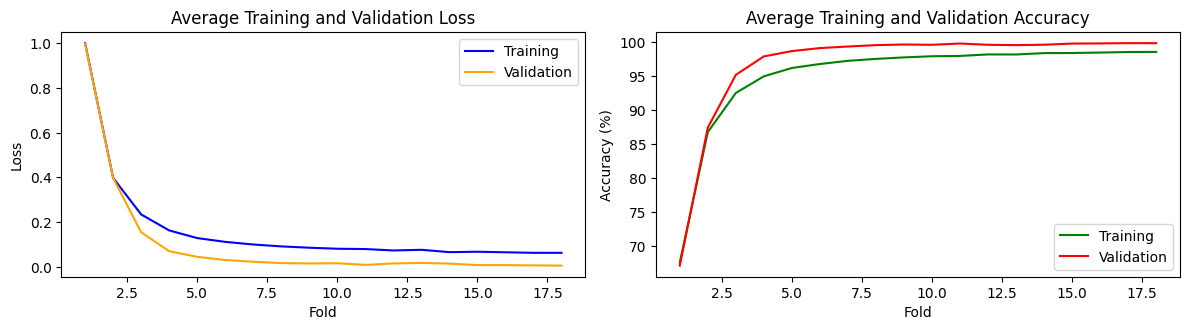

In [11]:
plt.figure(figsize=(12, 6))

# Plotting average training and validation losses
plt.subplot(2, 2, 1)
plt.plot(range(1, len(all_train_losses) + 1), all_train_losses, color='blue', label='Training')
plt.plot(range(1, len(all_val_losses) + 1), all_val_losses, color='orange', label='Validation')
plt.title('Average Training and Validation Loss')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend()

# Plotting average training and validation accuracies
plt.subplot(2, 2, 2)
plt.plot(range(1, len(all_train_accuracies) + 1), [acc * 100 for acc in all_train_accuracies], color='green', label='Training')
plt.plot(range(1, len(all_val_accuracies) + 1), [acc * 100 for acc in all_val_accuracies], color='red', label='Validation')
plt.title('Average Training and Validation Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
test_metrics = model.evaluate(images[data_test], labels[data_test])  
print("Test loss:", test_metrics[0])
print("Test accuracy:", test_metrics[1])

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - accuracy: 1.0000 - loss: 0.0020   
Test loss: 0.00189697474706918
Test accuracy: 1.0


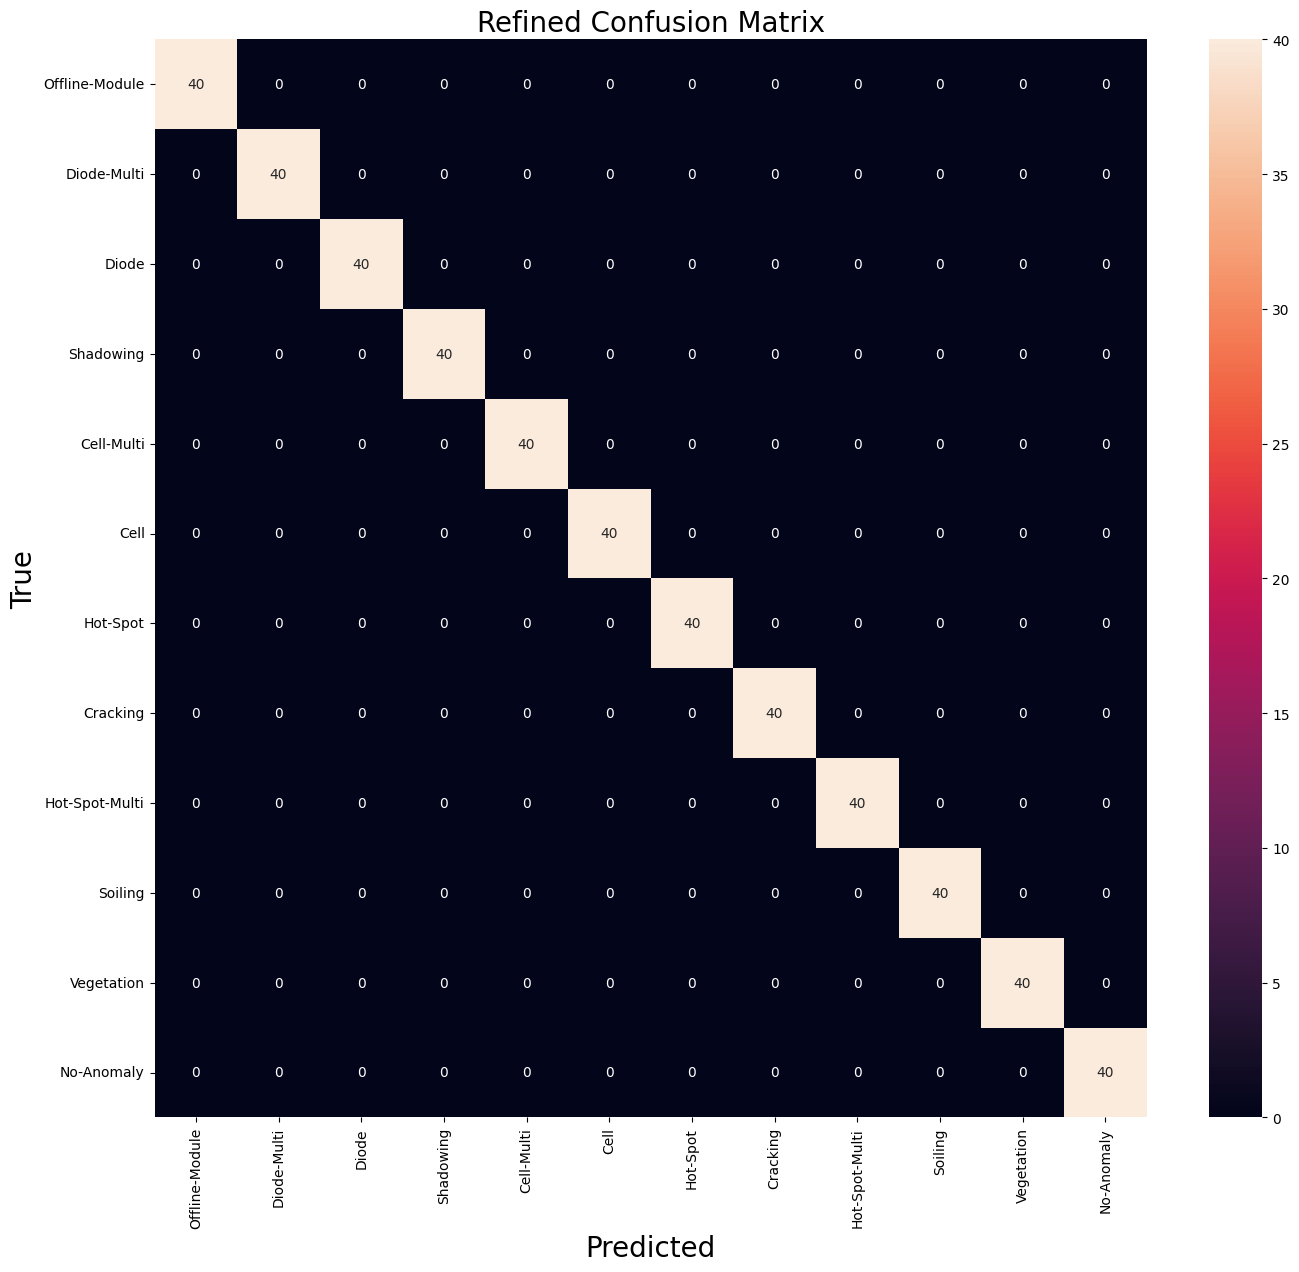

In [13]:
### Confusion Matrix
predictions = model.predict(images[data_test], steps=len(data_test), verbose=0)

y_pred = np.argmax(predictions, axis=-1)

cm = confusion_matrix(labels[data_test], y_pred)

## Get Class Labels
class_names = Classes

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True,robust=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

plt.show()

In [14]:
tp_and_fn = cm.sum(1)
tp_and_fp = cm.sum(0)
tp = cm.diagonal()
accuracy = cm.diagonal().sum()/cm.sum()
precision = tp / tp_and_fp
recall = tp / tp_and_fn
f1 = 2 * (precision * recall) / (precision + recall)
precision_avg=np.average(precision)
recall_avg=np.average(recall)
f1_avg=np.average(f1)

In [15]:
# Creating a dictionary with the data
data = {
    'Metrics': ['Accuracy', 'Average Precision', 'Average Recall', 'Average F1 Score'],
    'Values': [accuracy, precision_avg, recall_avg, f1_avg]
}

# Creating the DataFrame
df = pd.DataFrame(data)

# Displaying the DataFrame
print(df)

             Metrics  Values
0           Accuracy     1.0
1  Average Precision     1.0
2     Average Recall     1.0
3   Average F1 Score     1.0


In [16]:
data = {
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}

# Creating the DataFrame
df = pd.DataFrame(data)

# Displaying the DataFrame
print(df)

             Class  Precision  Recall  F1 Score
0   Offline-Module        1.0     1.0       1.0
1      Diode-Multi        1.0     1.0       1.0
2            Diode        1.0     1.0       1.0
3        Shadowing        1.0     1.0       1.0
4       Cell-Multi        1.0     1.0       1.0
5             Cell        1.0     1.0       1.0
6         Hot-Spot        1.0     1.0       1.0
7         Cracking        1.0     1.0       1.0
8   Hot-Spot-Multi        1.0     1.0       1.0
9          Soiling        1.0     1.0       1.0
10      Vegetation        1.0     1.0       1.0
11      No-Anomaly        1.0     1.0       1.0
